In [9]:
from pyxtal import pyxtal

In [10]:
import gzip
import json
with gzip.open('runs/zi1u9x4r/gnerated_wp_no_calibration.json.gz', 'rt') as f:
    generated_wychoffs = json.load(f)
print(f"Loaded {len(generated_wychoffs)} generated wychoffs")

Loaded 9614 generated wychoffs


In [11]:
from scipy.stats import wasserstein_distance, kstest

In [12]:
import pickle
with gzip.open("cache/mp_20_biternary/data.pkl.gz", "rb") as f:
    datasets_pd = pickle.load(f)

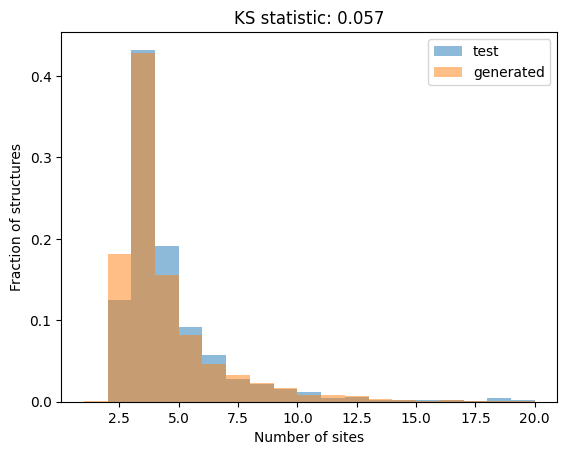

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
import numpy as np

test_no_sites = datasets_pd['test']['site_symmetries'].map(len)
generated_no_sites = [sum(map(len, wygene['sites'])) for wygene in generated_wychoffs]

bins = np.arange(1, 21)
ax.hist(test_no_sites, bins=bins, alpha=0.5, label='test', density=True)
ax.hist(generated_no_sites, bins=bins, alpha=0.5, label='generated', density=True)
ax.set_xlabel('Number of sites')
ax.set_ylabel('Fraction of structures')
#ax.set_title(f"Wasserstein_distance: {wasserstein_distance(test_no_sites, generated_no_sites):.2f}")
ax.set_title(f"KS statistic: {kstest(test_no_sites, generated_no_sites).statistic:.3f}")
ax.legend();

In [14]:
datasets_pd['test'].head()

,site_symmetries,elements,multiplicity,wyckoff_letters,sites_enumeration,dof,spacegroup_number,sites_enumeration_augmented,composition
6000,"[3m., 3m.]","[Ga, Te]","[4, 4]","[f, f]","[1, 1]","[1, 1]",194,"[[1, 1], [1, 1]]","{Ga: 4.0, Te: 4.0}"
42245,"[mmm, mmm]","[Cu, Ni]","[2, 2]","[c, a]","[2, 0]","[0, 0]",65,"[[2, 0], [0, 2], [1, 3], [3, 1], [2, 0], [0, 2...","{Cu: 1.0, Ni: 1.0}"
35749,"[m, m, m, m, m, m, 1, m, 1, m]","[Ho, Ho, Ho, Tm, Mn, Mn, Mn, Mn, Mn, Mn]","[2, 2, 2, 2, 2, 2, 4, 2, 4, 2]","[a, a, a, a, a, a, b, a, b, a]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 2, 2, 2, 2, 2, 3, 2, 3, 2]",8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]","{Ho: 3.0, Tm: 1.0, Mn: 8.0}"
37001,"[..2/m, ..2/m, ..m]","[Li, Mn, O]","[2, 2, 4]","[d, a, g]","[3, 0, 0]","[0, 0, 2]",58,"[[1, 3, 0], [1, 2, 0], [2, 1, 0], [3, 0, 0], [...","{Li: 4.0, Mn: 4.0, O: 8.0}"
20904,"[-32/m., 3m., 3m.]","[Fe, H, O]","[1, 2, 2]","[a, d, d]","[0, 1, 1]","[0, 1, 1]",164,"[[0, 1, 1], [1, 1, 1]]","{Fe: 4.0, H: 8.0, O: 8.0}"


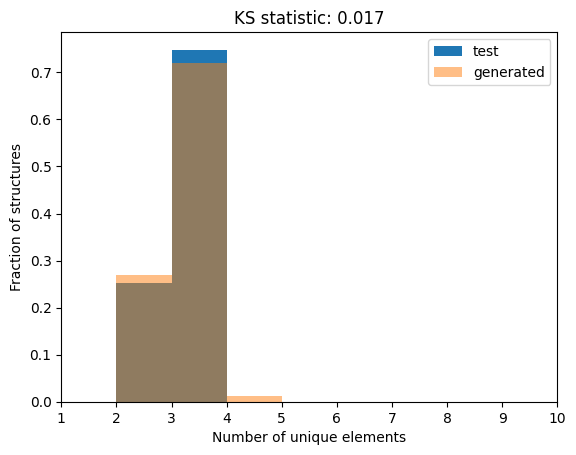

In [15]:
def count_elements(record):
    return len(set(record["species"]))
def count_elements_pd(record):
    return len(set(record.elements))
generated_no_elements = list(map(count_elements, generated_wychoffs))
test_no_elements = datasets_pd['test'].apply(count_elements_pd, axis=1)
fig, ax = plt.subplots()
bins = range(1, 10)
ax.hist(test_no_elements, label="test", density=True, bins=bins)
ax.hist(generated_no_elements, label="generated", density=True, alpha=0.5, bins=bins)
ax.set_xlabel("Number of unique elements")
ax.set_ylabel("Fraction of structures")
ax.legend()
#ax.set_title(f"Wasserstein distance: {wasserstein_distance(test_no_elements, generated_no_elements):.2f}")
ax.set_title(f"KS statistic: {kstest(test_no_elements, generated_no_elements).statistic:.3f}")
ax.set_xlim((1,10));

In [16]:
import pickle
with open("cache/wychoffs_enumerated_by_ss.pkl.gz", "rb") as f:
    a, letter_from_ss_enum, ss_from_letter = pickle.load(f)
def extract_ss(wychoff_gene):
    res = []
    for sites_list in wychoff_gene['sites']:
        res.extend([ss_from_letter[wychoff_gene['group']][multi_letter.lstrip("1234567890")] for multi_letter in sites_list])
    return res

In [17]:
from collections import Counter
from itertools import chain
test_ss_frequency = Counter(chain(*datasets_pd['test']['site_symmetries']))
generated_ss_frequency = Counter(chain(*map(extract_ss, generated_wychoffs)))

In [18]:
sorted_ss, test_count = map(list, zip(*sorted(test_ss_frequency.items(), key=lambda x: x[1], reverse=True)))
test_count = np.array(test_count)
generated_count = [generated_ss_frequency[ss] for ss in sorted_ss]
generated_count = np.array(generated_count)

generated_count = generated_count / generated_count.sum()
test_count = test_count / test_count.sum()

In [19]:
exclusion_mask = ~((test_count == 0) | (generated_count == 0))

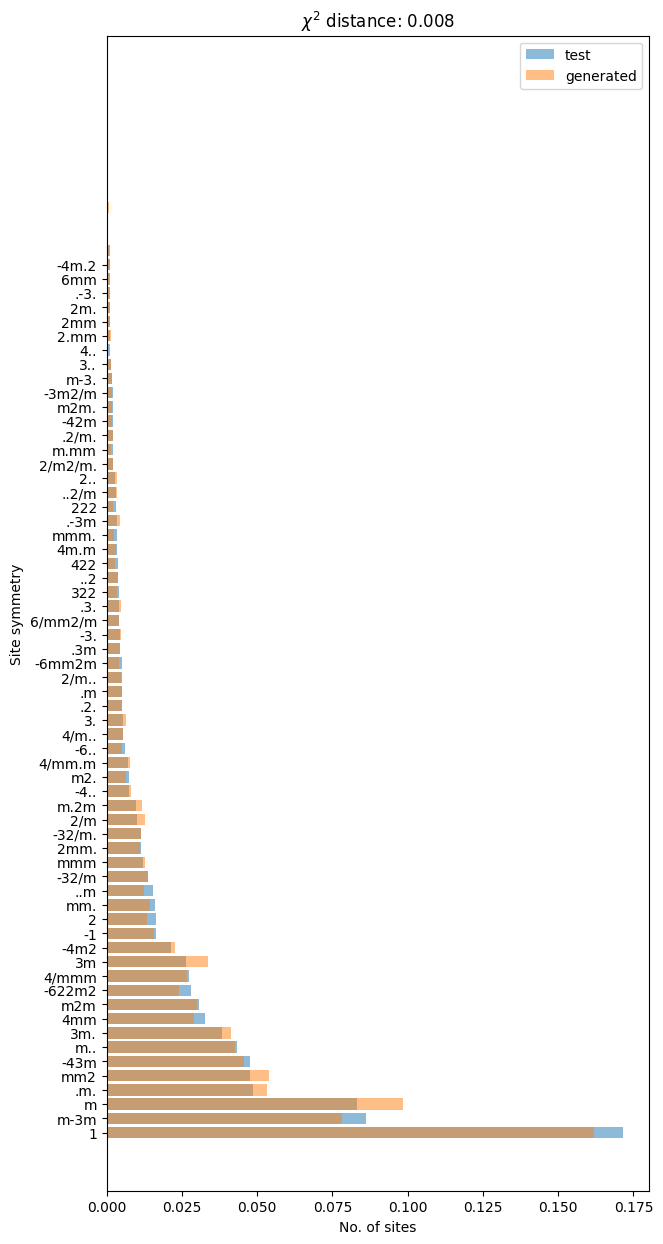

In [20]:
from scipy.stats import chi2_contingency
chi2_results = chi2_contingency(np.vstack([test_count[exclusion_mask], generated_count[exclusion_mask]]))
print("WARNING: chi2 needs counts, not frequencies")
fig, ax = plt.subplots(figsize=(7, 15))
ax.barh(range(len(sorted_ss)), test_count, alpha=0.5, label='test')
ax.barh(range(len(sorted_ss)), generated_count, alpha=0.5, label='generated')
ax.set_xlabel('No. of sites')
ax.set_ylabel('Site symmetry');
ax.set_title(f"$\\chi^2$ distance: {chi2_results[0]:.3f}")
high_bins = test_count > 0.001
ax.set_yticks(np.nonzero(high_bins)[0])
ax.set_yticklabels([sorted_ss[i] for i in np.nonzero(high_bins)[0]])
ax.legend();

In [21]:
test_elements_count = Counter()
for element, mutliplicity in zip(chain(*datasets_pd['test']['elements']),
                                 chain(*datasets_pd['test']['multiplicity'])):
    test_elements_count[element] += mutliplicity

In [22]:
from pymatgen.core import Element
generated_elements_count = Counter()
for wychoff_gene in generated_wychoffs:
    for element, multiplicity in zip(wychoff_gene['species'], wychoff_gene['numIons']):
        generated_elements_count[Element(element)] += multiplicity

In [23]:
test_elements_count_np = np.array([test_elements_count[element] for element in generated_elements_count])
generated_elements_count_np = np.array([generated_elements_count[element] for element in generated_elements_count])
exclusion_mask = ~((test_elements_count_np == 0) | (generated_elements_count_np == 0))
chi2_results = chi2_contingency(np.vstack([test_elements_count_np[exclusion_mask], generated_elements_count_np[exclusion_mask]]))

In [24]:
test_elements_count_np = test_elements_count_np / test_elements_count_np.sum()
generated_elements_count_np = generated_elements_count_np / generated_elements_count_np.sum()

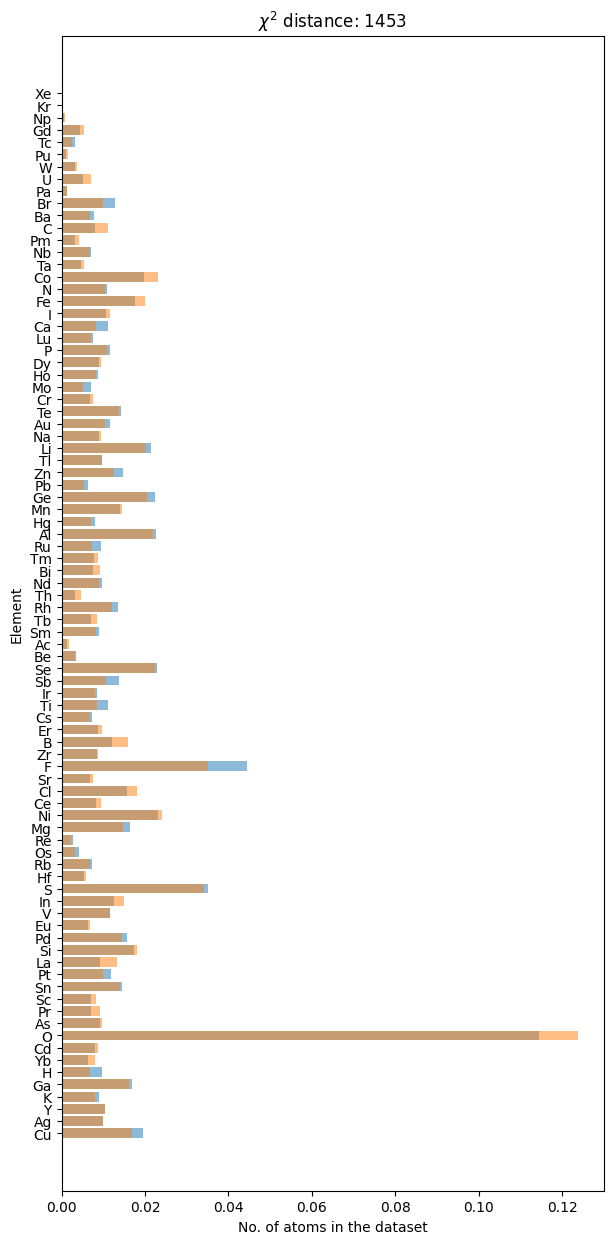

In [25]:
fig, ax = plt.subplots(figsize=(7, 15))
ax.barh(range(len(generated_elements_count)), test_elements_count_np, alpha=0.5, label='test')
ax.barh(range(len(generated_elements_count)), generated_elements_count_np, alpha=0.5, label='generated')
ax.set_xlabel('No. of atoms in the dataset')
ax.set_ylabel('Element')
ax.set_title(f"$\\chi^2$ distance: {chi2_results[0]:.0f}")
high_count = -1
high_bins = test_elements_count_np > high_count
ticks = np.nonzero(high_bins)[0]
ax.set_yticks(ticks)
ax.set_yticklabels([tuple(generated_elements_count.keys())[i] for i in ticks]);

In [26]:
from collections import defaultdict
from pyxtal.symmetry import Group
dof_from_letter = defaultdict(dict)
for group_number in range(1, 231):
    group = Group(group_number)
    for wp in group.Wyckoff_positions:
        wp.get_site_symmetry()
        dof_from_letter[group_number][wp.letter] = wp.get_dof()

In [27]:
def get_total_dof(wychoff_gene):
    dof = sum(map(lambda site: dof_from_letter[wychoff_gene['group']][site.lstrip('1234567890')],
                  chain(*wychoff_gene['sites'])))
    return dof

In [28]:
generated_dof = np.array([get_total_dof(wg) for wg in generated_wychoffs])

In [29]:
test_dof = datasets_pd['test']['dof'].apply(sum)

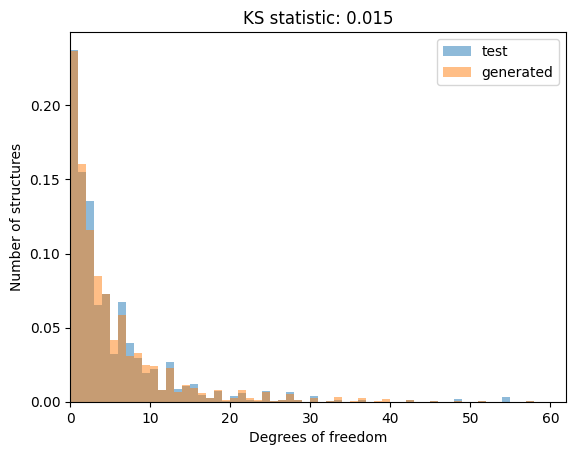

In [30]:
fig, ax = plt.subplots()
bins=range(test_dof.max())
ax.hist(test_dof, bins=bins, alpha=0.5, label='test', density=True)
ax.hist(generated_dof, bins=bins, alpha=0.5, label='generated', density=True)
ax.set_xlabel('Degrees of freedom')
ax.set_ylabel('Number of structures')
ax.set_title(f"KS statistic: {kstest(test_dof, generated_dof).statistic:.3f}")
ax.legend()
ax.set_xlim(0);